In [1]:
from skimage import metrics
from skimage.filters import threshold_otsu
from skimage.feature import blob_log, blob_dog
import torch
import numpy as np
import os
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from generative_ai.src.dataloader import DendritePFMDataset
from scipy import ndimage as ndi
from math import sqrt
from mpl_toolkits.mplot3d import Axes3D  # noqa

# --- global plotting config ---
plt.rcParams["image.cmap"] = "coolwarm"

# --- fractal dimension (box-counting) ---
def fractal_dimension_boxcount(img, threshold=None, n_scales=8, min_box_size=2):
    """Estimate 2D fractal dimension D_f via box-counting."""
    if img.ndim == 3:
        img = img.mean(axis=-1)
    img = img.astype(float)

    if threshold is None:
        threshold = threshold_otsu(img)
    Z = img > threshold

    p = min(Z.shape)
    max_box_size = max(min_box_size + 1, p // 2)

    sizes = np.logspace(
        np.log10(min_box_size), np.log10(max_box_size),
        num=n_scales, dtype=int
    )
    sizes = np.unique(sizes)

    counts = []
    for size in sizes:
        S = np.add.reduceat(
            np.add.reduceat(Z, np.arange(0, Z.shape[0], size), axis=0),
            np.arange(0, Z.shape[1], size), axis=1
        )
        counts.append(np.count_nonzero(S))

    sizes = sizes[np.array(counts) > 0]
    counts = np.array(counts)[np.array(counts) > 0]

    log_inv_eps = np.log(1.0 / sizes.astype(float))
    log_N = np.log(counts)

    coeffs = np.polyfit(log_inv_eps, log_N, 1)
    return coeffs[0], sizes, counts


# --- shape index ---
def shape_index(img):
    """Continuous shape index in [0,1] from principal curvatures approximation."""
    gy, gx = np.gradient(img)
    gyy, gyx = np.gradient(gy)
    gxy, gxx = np.gradient(gx)
    H = (gxx + gyy) / 2.0
    K = gxx * gyy - gxy * gyx
    return np.arctan2(H, np.sqrt(np.abs(H**2 - K))) / np.pi + 0.5


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

test_dataset = DendritePFMDataset(
    (3, 64, 64),
    os.path.join("data", "dataset_split.json"),
    split="test"
)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=True)

vae = torch.load(os.path.join(
    "results/V4_noise0.1_fft0.001_tv0.0005_smooth0.005_grad0.001_20251114_161233",
    "ckpt", "CVAE.ckpt"
)).to(device)


C:\Users\u0178651a\AppData\Local\Temp\ipykernel_7460\3355738383.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae = torch.load(os.path.join(


In [3]:
rmses = []
ssims = []
dfs_gt = []
dfs_pd = []

vis_samples = []  # store up to 5 random samples for detailed visualization
max_vis_samples = 5

with torch.no_grad():
    for idx, (x, y, did, xo) in enumerate(test_dataloader):
        # forward
        recon_x = vae.inference(y)

        # --- convert to numpy for metrics ---
        x_np = x.cpu().numpy()[0].transpose(1, 2, 0)          # (H,W,C)
        recon_np = recon_x.cpu().numpy()[0].transpose(1, 2, 0)

        # --- RMSE & μSIM (SSIM) ---
        rmse_val = metrics.normalized_root_mse(x_np, recon_np)
        rmses.append(rmse_val)

        ssim_val = metrics.structural_similarity(
            x_np, recon_np,
            win_size=3,
            data_range=(x.max() - x.min()).item()
        )
        ssims.append(ssim_val)

        # --- fractal dimension on channel 0 ---
        img_gt = x.detach().cpu().numpy()[0, 0, :, :]
        img_pd = recon_x.detach().cpu().numpy()[0, 0, :, :]

        Df_gt, _, _ = fractal_dimension_boxcount(img_gt)
        Df_pd, _, _ = fractal_dimension_boxcount(img_pd)

        dfs_gt.append(Df_gt)
        dfs_pd.append(Df_pd)

        # --- store a few samples for detailed shape/blob visualization ---
        if len(vis_samples) < max_vis_samples:
            vis_samples.append({
                "idx": idx,
                "x": x.detach().cpu(),
                "recon_x": recon_x.detach().cpu()
            })

# convert to numpy arrays for later
rmses = np.array(rmses)
ssims = np.array(ssims)
dfs_gt = np.array(dfs_gt)
dfs_pd = np.array(dfs_pd)

print(f"Total test samples: {len(rmses)}")
print(f"Stored {len(vis_samples)} samples for shape/blob visualization.")


Total test samples: 162
Stored 5 samples for shape/blob visualization.


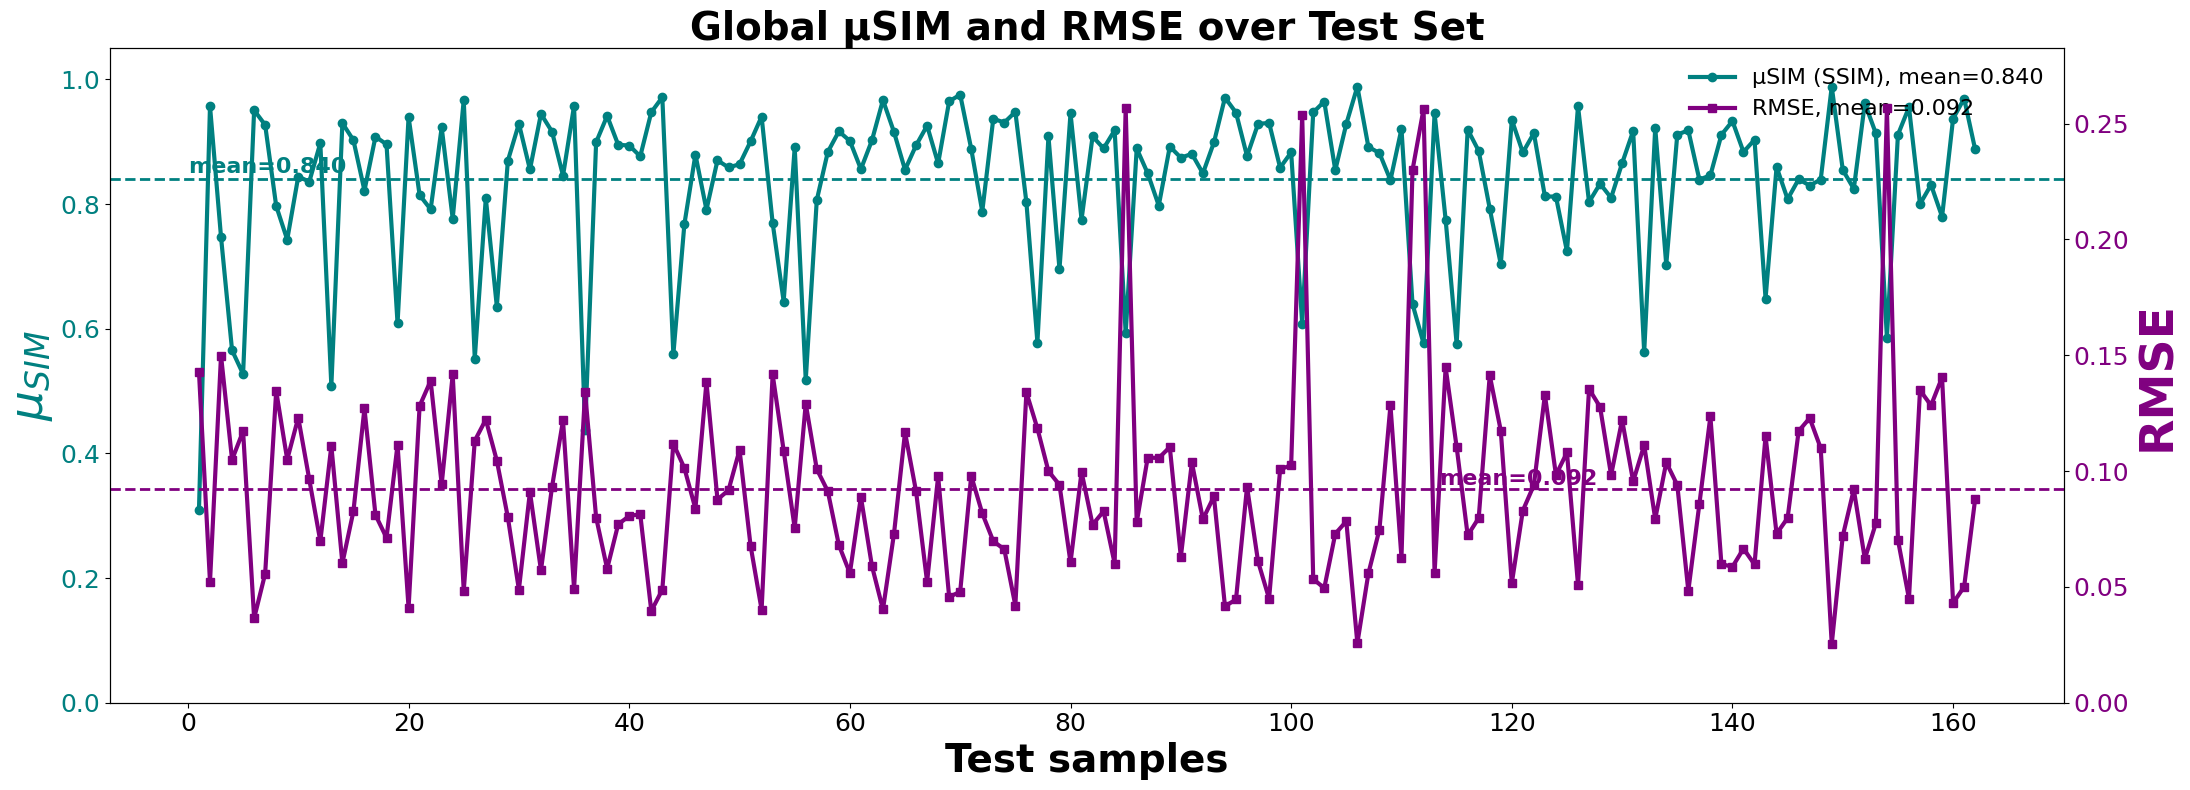

In [4]:
plt.rcParams['figure.figsize'] = (22, 8)

x_ids = np.arange(1, len(ssims) + 1)
ssim_avg = ssims.mean()
rmse_avg = rmses.mean()

fig, ax1 = plt.subplots()

# μSIM
l1 = ax1.plot(x_ids, ssims, '-o', color='teal', linewidth=3, markersize=6,
              label=f'μSIM (SSIM), mean={ssim_avg:.3f}')
ax1.set_xlabel("Test samples", size=28, weight='bold')
ax1.set_ylabel(r"$\mu_{SIM}$", size=34, color='teal', weight='bold')
ax1.tick_params(axis='y', labelcolor='teal', labelsize=18)
ax1.tick_params(axis='x', labelcolor='black', labelsize=18)
ax1.set_ylim([0.0, 1.05])

# annotate mean line
ax1.axhline(ssim_avg, color='teal', linestyle='--', linewidth=2)
ax1.text(0.01, ssim_avg + 0.01, f"mean={ssim_avg:.3f}",
         color='teal', fontsize=16, weight='bold')

# RMSE (right axis)
ax2 = ax1.twinx()
l2 = ax2.plot(x_ids, rmses, '-s', color='purple', linewidth=3, markersize=6,
              label=f'RMSE, mean={rmse_avg:.3f}')
ax2.set_ylabel("RMSE", size=34, color='purple', weight='bold')
ax2.tick_params(axis='y', labelcolor='purple', labelsize=18)
ax2.set_ylim([0, rmses.max() * 1.1])

ax2.axhline(rmse_avg, color='purple', linestyle='--', linewidth=2)
ax2.text(len(x_ids) * 0.7, rmse_avg * 1.02, f"mean={rmse_avg:.3f}",
         color='purple', fontsize=16, weight='bold')

# combined legend
lines = l1 + l2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right', fontsize=16, frameon=False)

plt.title("Global μSIM and RMSE over Test Set", fontsize=28, weight='bold')
plt.tight_layout()
plt.show()


Fractal Dimension GT   : mean = 1.603 ± 0.278
Fractal Dimension Pred : mean = 1.582 ± 0.130
ΔD_f (Pred-GT)         : mean = -0.022 ± 0.299
|ΔD_f|                 : mean = 0.238 ± 0.182


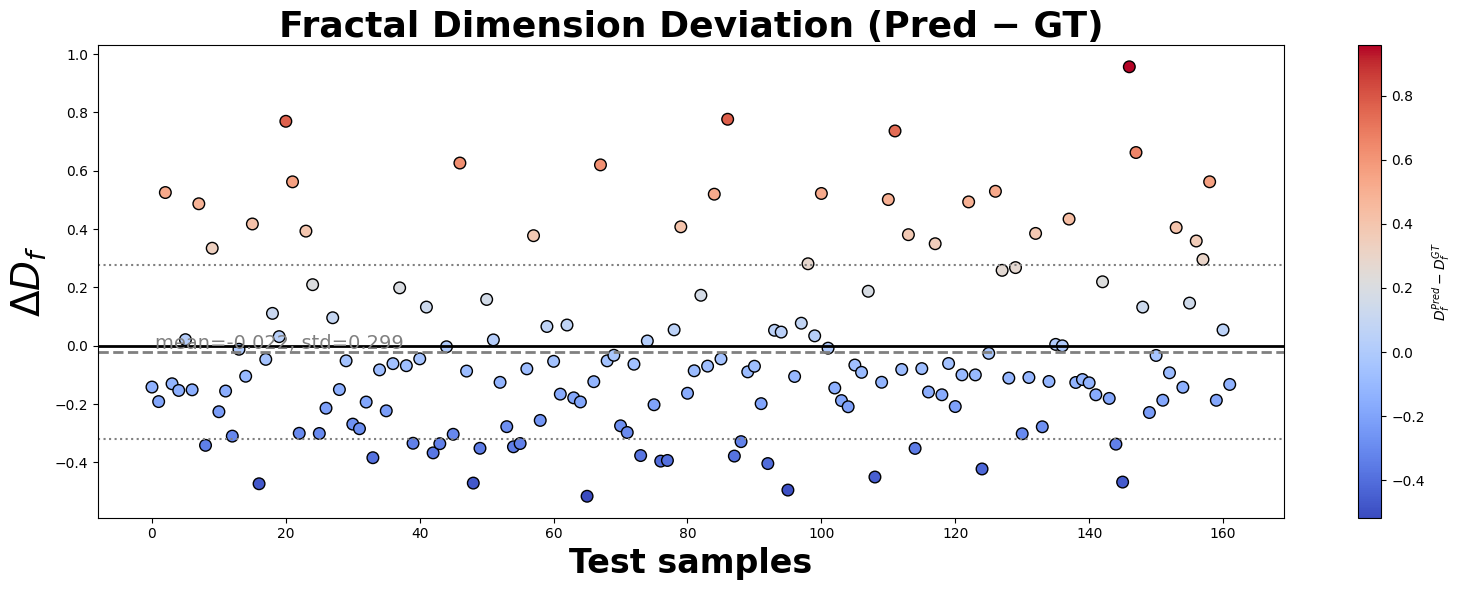

In [5]:
df_diff = dfs_pd - dfs_gt
df_abs = np.abs(df_diff)

Df_gt_mean, Df_gt_std = dfs_gt.mean(), dfs_gt.std()
Df_pd_mean, Df_pd_std = dfs_pd.mean(), dfs_pd.std()
Df_diff_mean, Df_diff_std = df_diff.mean(), df_diff.std()
Df_abs_mean, Df_abs_std = df_abs.mean(), df_abs.std()

print(f"Fractal Dimension GT   : mean = {Df_gt_mean:.3f} ± {Df_gt_std:.3f}")
print(f"Fractal Dimension Pred : mean = {Df_pd_mean:.3f} ± {Df_pd_std:.3f}")
print(f"ΔD_f (Pred-GT)         : mean = {Df_diff_mean:.3f} ± {Df_diff_std:.3f}")
print(f"|ΔD_f|                 : mean = {Df_abs_mean:.3f} ± {Df_abs_std:.3f}")

plt.figure(figsize=(16, 6))

sc = plt.scatter(
    np.arange(len(df_diff)), df_diff,
    c=df_diff, cmap='coolwarm', s=70, edgecolors='k'
)
plt.axhline(0.0, color='black', linewidth=2)
plt.colorbar(sc, label=r"$D_f^{Pred} - D_f^{GT}$")

plt.xlabel("Test samples", fontsize=24, weight='bold')
plt.ylabel(r"$\Delta D_f$", fontsize=28, weight='bold')
plt.title("Fractal Dimension Deviation (Pred − GT)", fontsize=26, weight='bold')

# annotate mean and ±std
plt.axhline(Df_diff_mean, color='gray', linestyle='--', linewidth=2)
plt.axhline(Df_diff_mean + Df_diff_std, color='gray', linestyle=':', linewidth=1.5)
plt.axhline(Df_diff_mean - Df_diff_std, color='gray', linestyle=':', linewidth=1.5)
plt.text(0.5, Df_diff_mean + 0.01,
         f"mean={Df_diff_mean:.3f}, std={Df_diff_std:.3f}",
         fontsize=14, color='gray')

plt.tight_layout()
plt.show()


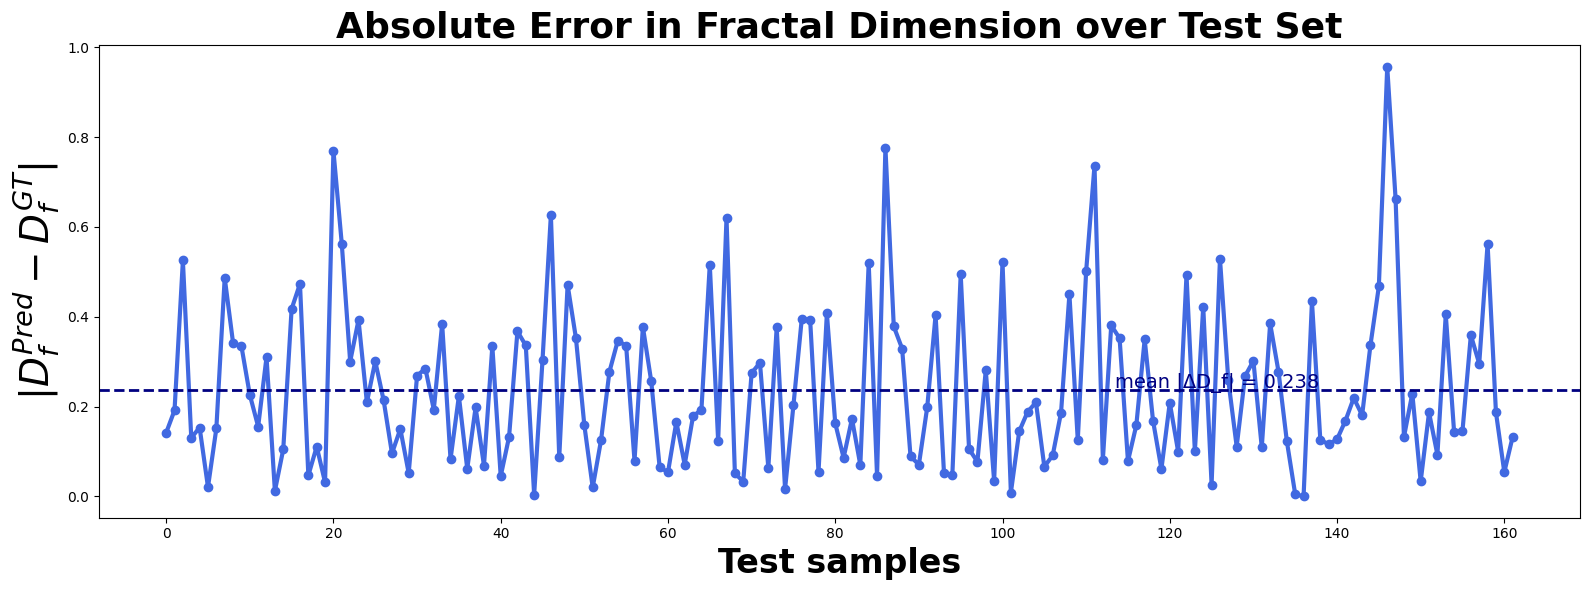

In [6]:
plt.figure(figsize=(16, 6))
plt.plot(df_abs, '-o', color='royalblue', linewidth=3, markersize=6)
plt.xlabel("Test samples", fontsize=24, weight='bold')
plt.ylabel(r"$|D_f^{Pred}-D_f^{GT}|$", fontsize=28, weight='bold')
plt.title("Absolute Error in Fractal Dimension over Test Set",
          fontsize=26, weight='bold')

# annotate mean line
plt.axhline(Df_abs_mean, color='navy', linestyle='--', linewidth=2)
plt.text(len(df_abs)*0.7, Df_abs_mean*1.02,
         f"mean |ΔD_f| = {Df_abs_mean:.3f}",
         fontsize=14, color='navy')

plt.tight_layout()
plt.show()


Shape index visualization on 5 random test samples (channel 0)
target=0.0, delta=0.3, sigma=0.5


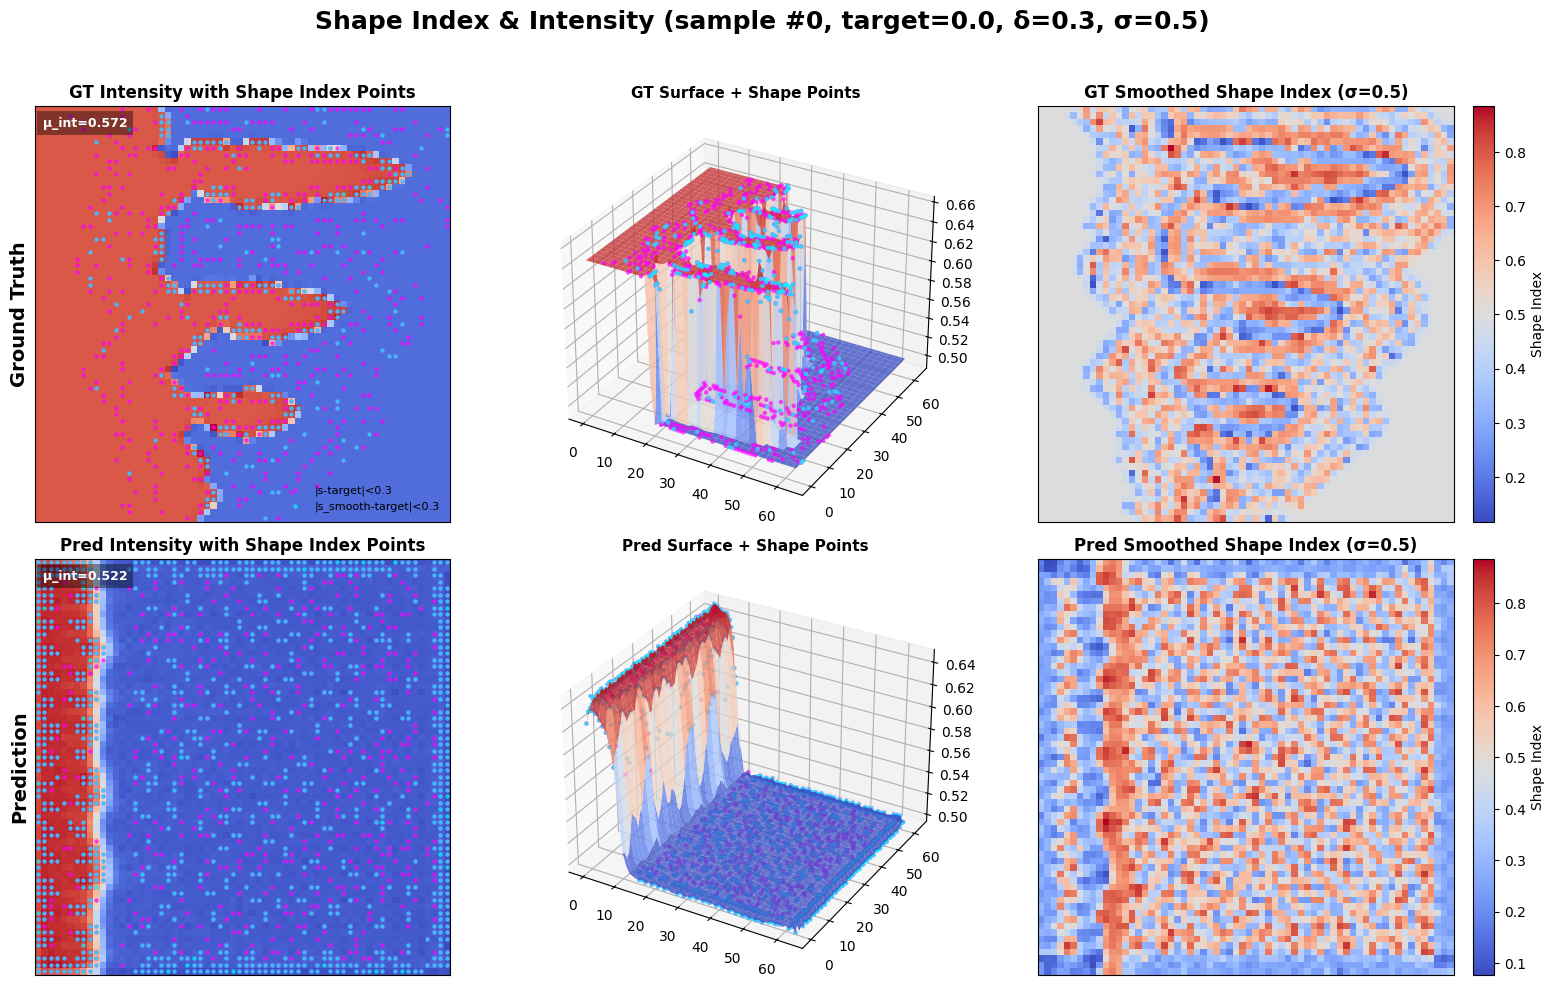

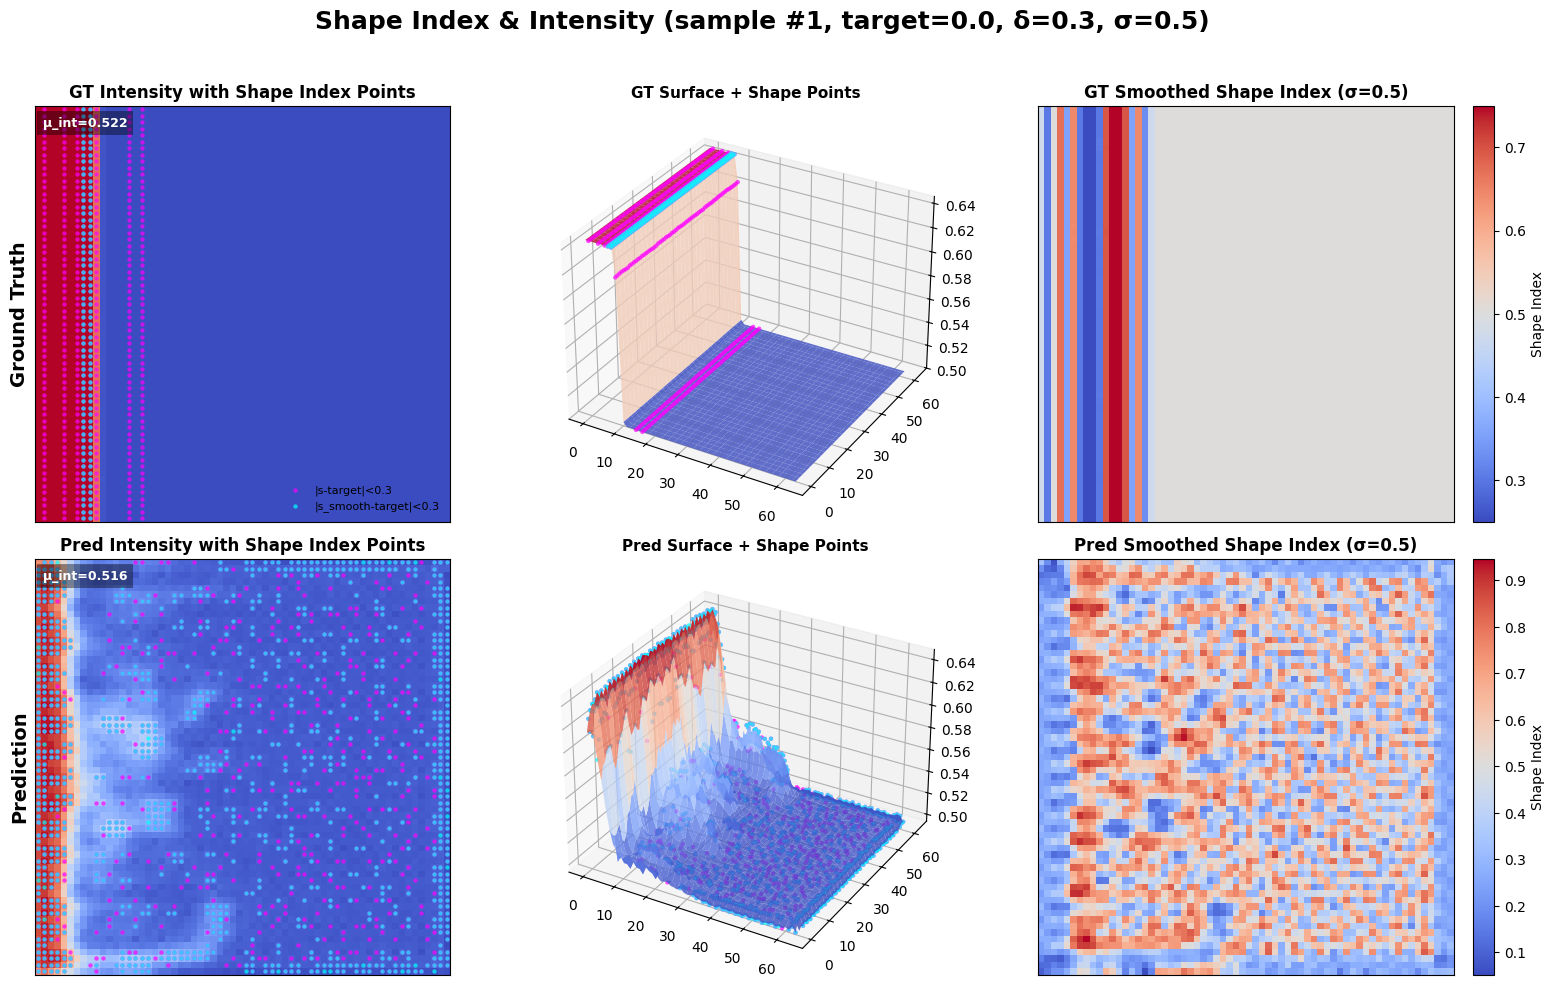

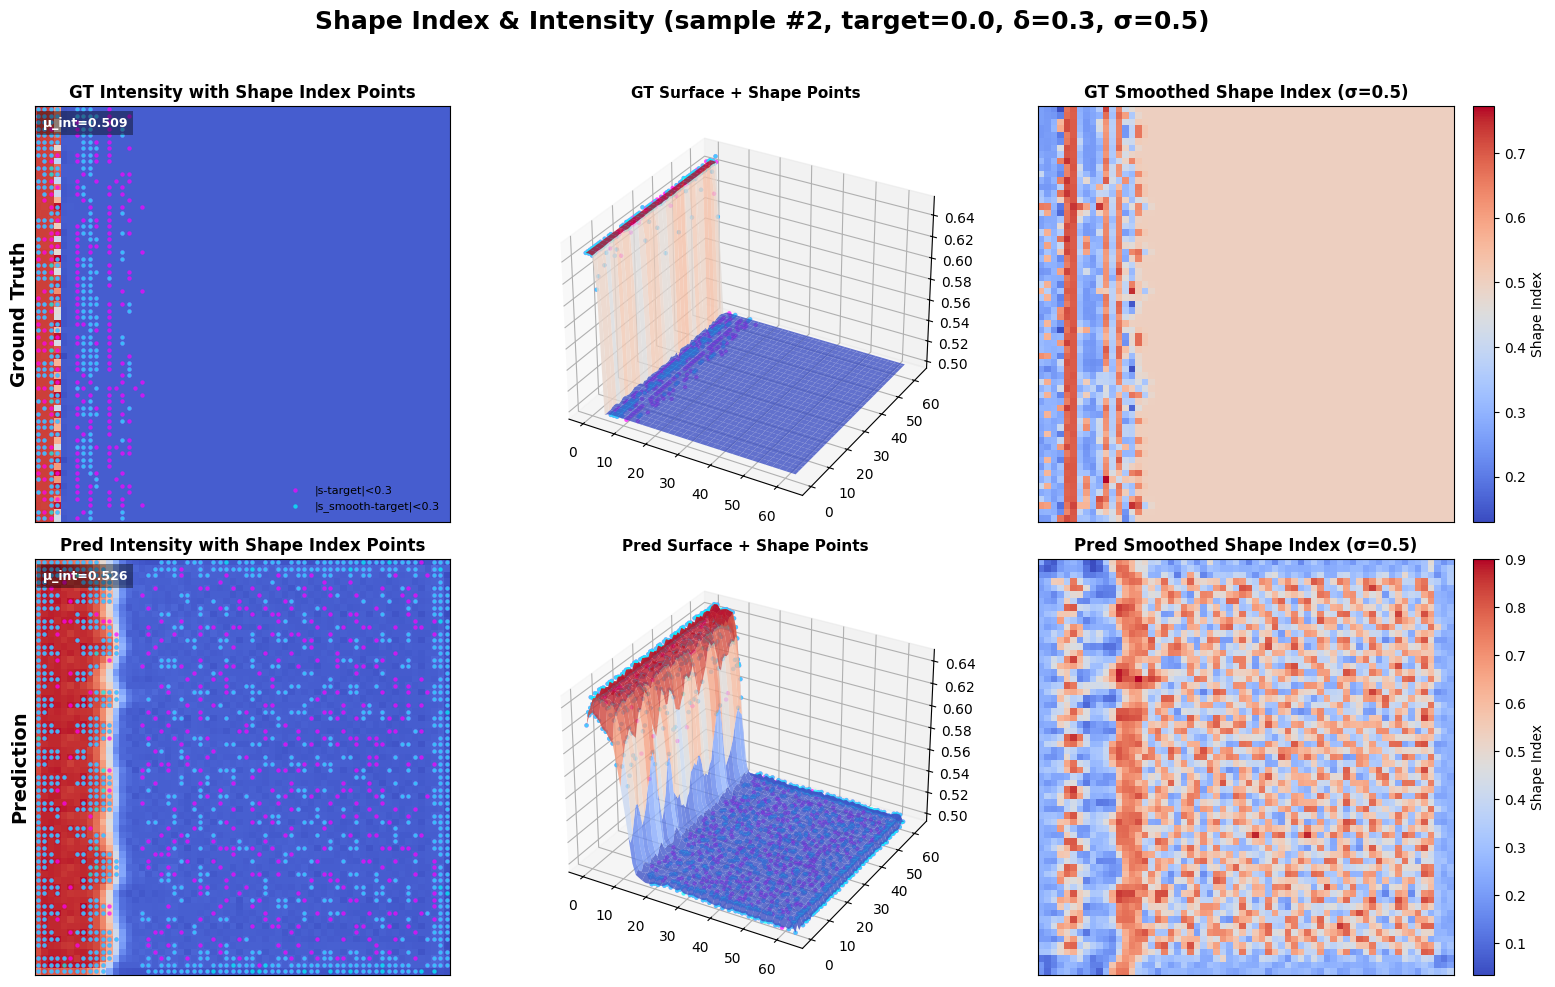

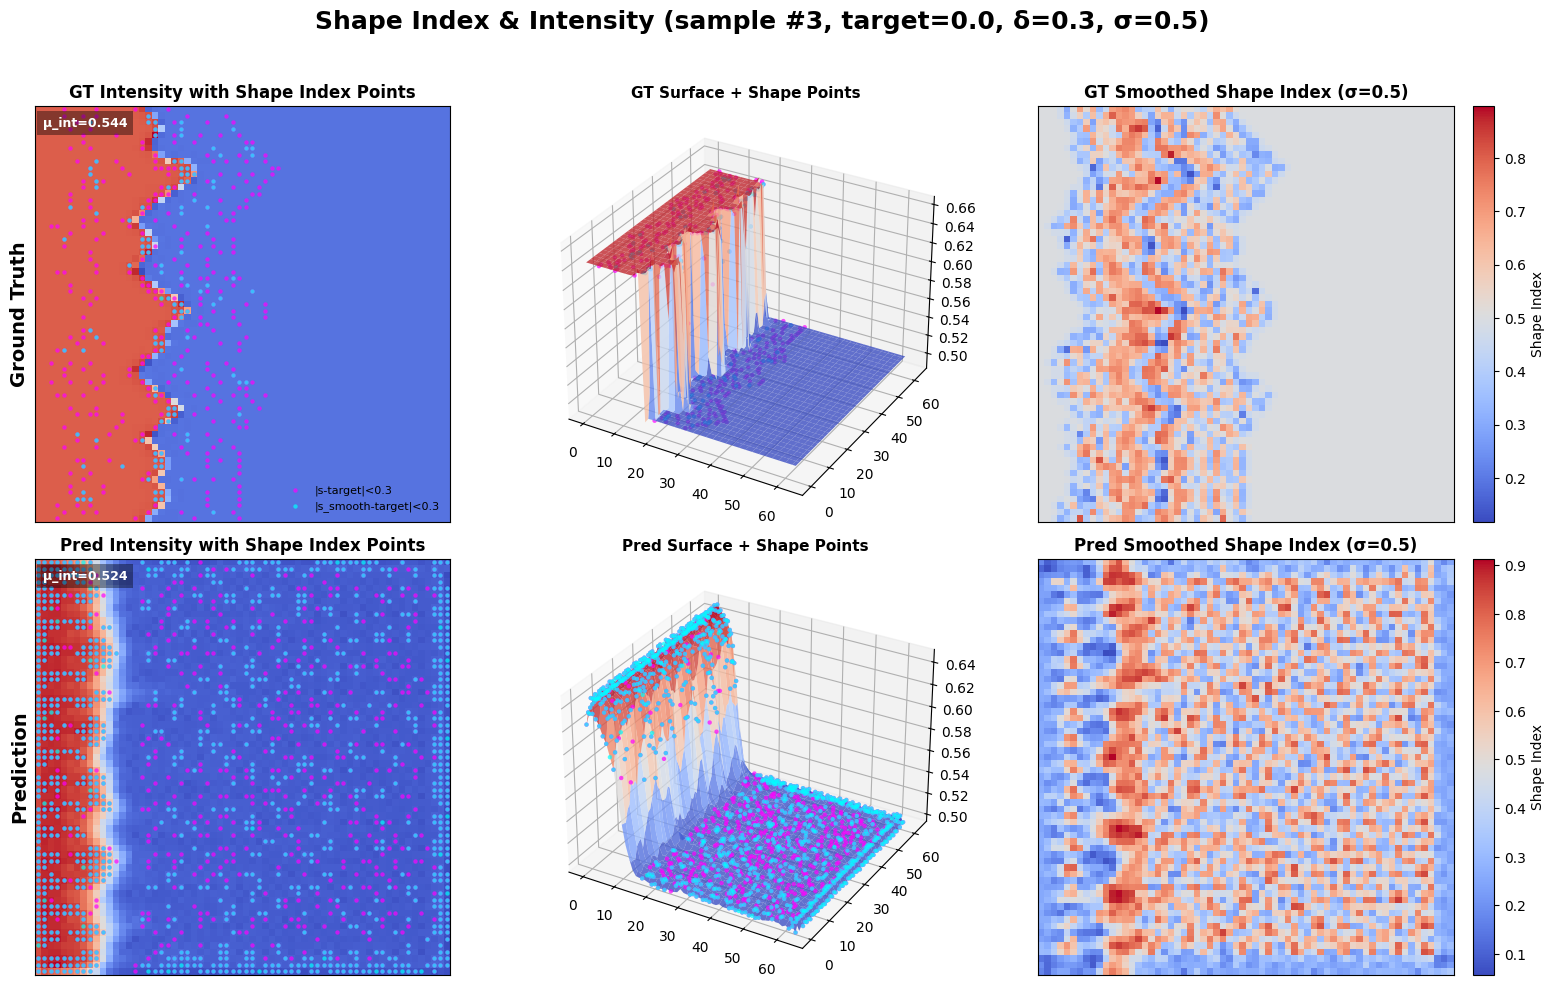

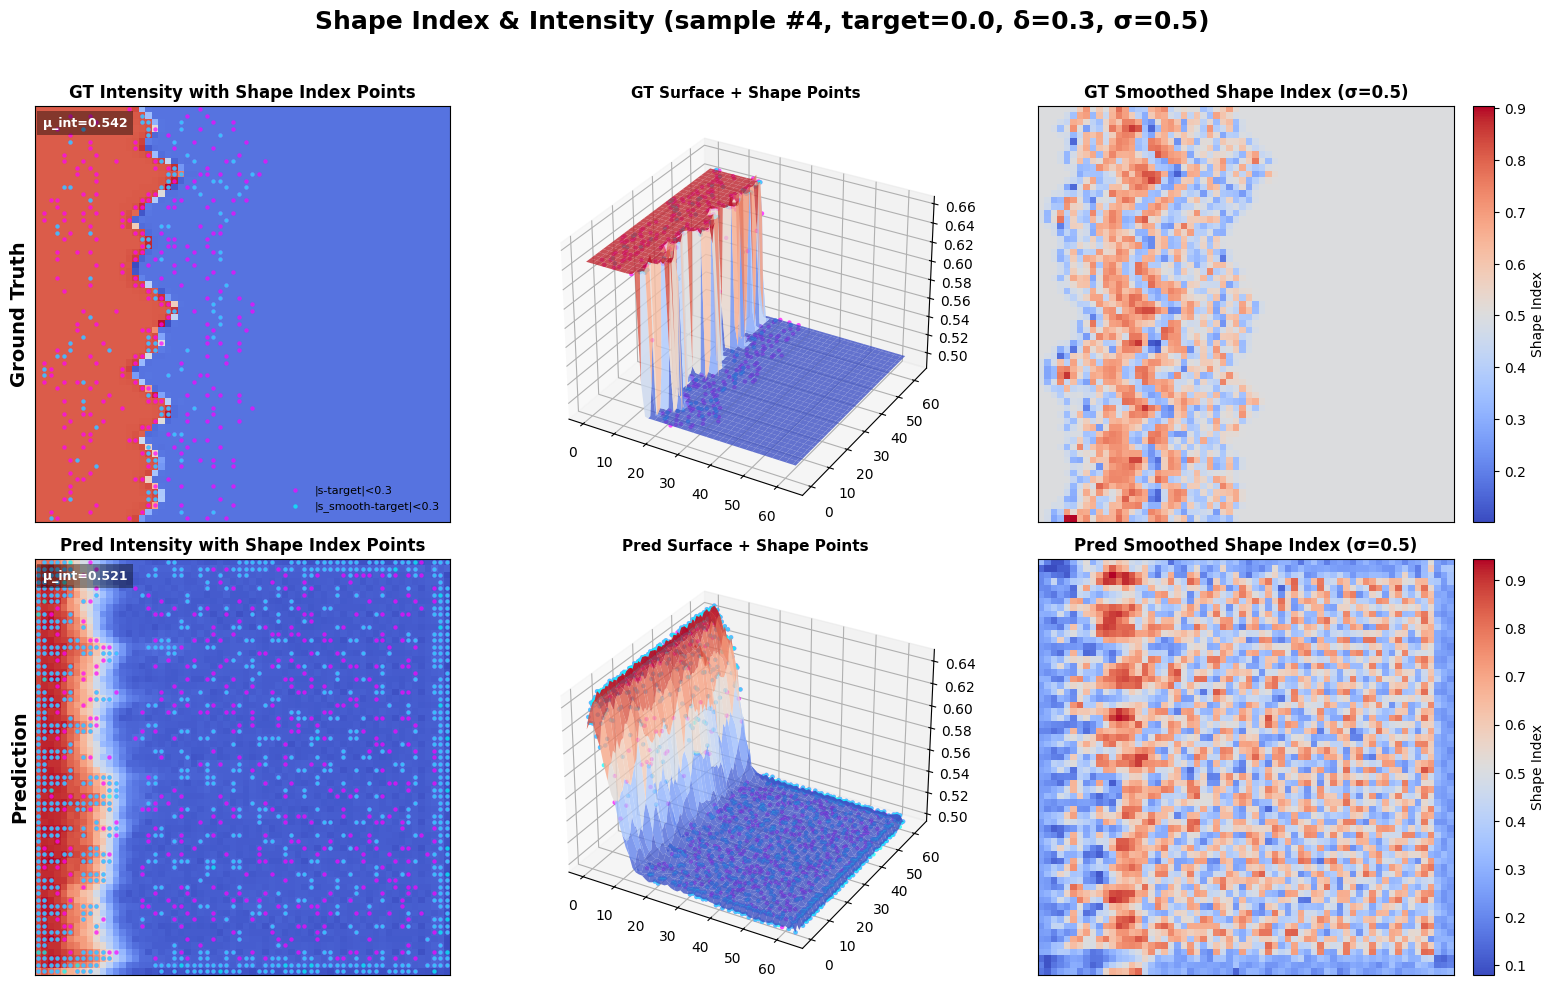

In [7]:
# Parameters for shape-index-based point selection
target = 0.0
delta = 0.3
sigma = 0.5  # Gaussian smoothing

print(f"Shape index visualization on {len(vis_samples)} random test samples (channel 0)")
print(f"target={target}, delta={delta}, sigma={sigma}")

for sample in vis_samples:
    idx = sample["idx"]
    x_s = sample["x"]
    recon_s = sample["recon_x"]

    gt_img = x_s.numpy()[0, 0, :, :]
    pd_img = recon_s.numpy()[0, 0, :, :]

    # shape index and smoothed
    s_gt = shape_index(gt_img)
    s_pd = shape_index(pd_img)

    s_gt_smooth = ndi.gaussian_filter(s_gt, sigma=sigma)
    s_pd_smooth = ndi.gaussian_filter(s_pd, sigma=sigma)

    # mask for points near target
    py_gt, px_gt = np.where(np.abs(s_gt - target) < delta)
    py_gt_s, px_gt_s = np.where(np.abs(s_gt_smooth - target) < delta)

    py_pd, px_pd = np.where(np.abs(s_pd - target) < delta)
    py_pd_s, px_pd_s = np.where(np.abs(s_pd_smooth - target) < delta)

    # intensity values for 3D scatter
    pz_gt = gt_img[py_gt, px_gt]
    pz_gt_s = gt_img[py_gt_s, px_gt_s]
    pz_pd = pd_img[py_pd, px_pd]
    pz_pd_s = pd_img[py_pd_s, px_pd_s]

    fig = plt.figure(figsize=(16, 10))
    plt.suptitle(
        f"Shape Index & Intensity (sample #{idx}, target={target}, δ={delta}, σ={sigma})",
        fontsize=18, weight='bold'
    )

    scatter_settings = dict(alpha=0.7, s=10, linewidths=0)

    # --- Row 1: GT ---
    ax1 = fig.add_subplot(2, 3, 1)
    im1 = ax1.imshow(gt_img, cmap='coolwarm')
    ax1.set_title("GT Intensity with Shape Index Points", fontsize=12, weight='bold')
    ax1.scatter(px_gt, py_gt, color='magenta', label=f'|s-target|<{delta}', **scatter_settings)
    ax1.scatter(px_gt_s, py_gt_s, color='cyan', label=f'|s_smooth-target|<{delta}', **scatter_settings)
    ax1.set_ylabel("Ground Truth", fontsize=14, weight='bold')
    ax1.legend(loc="lower right", fontsize=8, frameon=False)

    mean_int_gt = gt_img.mean()
    ax1.text(0.02, 0.95, f"μ_int={mean_int_gt:.3f}",
             transform=ax1.transAxes, color='white',
             fontsize=9, weight='bold',
             bbox=dict(facecolor='black', alpha=0.4, edgecolor='none'))

    ax2 = fig.add_subplot(2, 3, 2, projection='3d')
    Xg, Yg = np.meshgrid(np.arange(gt_img.shape[1]), np.arange(gt_img.shape[0]))
    surf1 = ax2.plot_surface(Xg, Yg, gt_img, cmap='coolwarm', alpha=0.8, edgecolor='none')
    ax2.scatter(px_gt, py_gt, pz_gt, color='magenta', **scatter_settings)
    ax2.scatter(px_gt_s, py_gt_s, pz_gt_s, color='cyan', **scatter_settings)
    ax2.set_title("GT Surface + Shape Points", fontsize=11, weight='bold')
    ax2.set_zlim(float(gt_img.min()), float(gt_img.max()))

    ax3 = fig.add_subplot(2, 3, 3)
    im3 = ax3.imshow(s_gt_smooth, cmap='coolwarm')
    ax3.set_title(f"GT Smoothed Shape Index (σ={sigma})", fontsize=12, weight='bold')
    cb3 = plt.colorbar(im3, ax=ax3, fraction=0.046, pad=0.04)
    cb3.set_label("Shape Index", fontsize=10)

    # --- Row 2: Pred ---
    ax4 = fig.add_subplot(2, 3, 4)
    im4 = ax4.imshow(pd_img, cmap='coolwarm')
    ax4.set_title("Pred Intensity with Shape Index Points", fontsize=12, weight='bold')
    ax4.set_ylabel("Prediction", fontsize=14, weight='bold')
    ax4.scatter(px_pd, py_pd, color='magenta', **scatter_settings)
    ax4.scatter(px_pd_s, py_pd_s, color='cyan', **scatter_settings)

    mean_int_pd = pd_img.mean()
    ax4.text(0.02, 0.95, f"μ_int={mean_int_pd:.3f}",
             transform=ax4.transAxes, color='white',
             fontsize=9, weight='bold',
             bbox=dict(facecolor='black', alpha=0.4, edgecolor='none'))

    ax5 = fig.add_subplot(2, 3, 5, projection='3d')
    Xp, Yp = np.meshgrid(np.arange(pd_img.shape[1]), np.arange(pd_img.shape[0]))
    surf2 = ax5.plot_surface(Xp, Yp, pd_img, cmap='coolwarm', alpha=0.8, edgecolor='none')
    ax5.scatter(px_pd, py_pd, pz_pd, color='magenta', **scatter_settings)
    ax5.scatter(px_pd_s, py_pd_s, pz_pd_s, color='cyan', **scatter_settings)
    ax5.set_title("Pred Surface + Shape Points", fontsize=11, weight='bold')
    ax5.set_zlim(float(pd_img.min()), float(pd_img.max()))

    ax6 = fig.add_subplot(2, 3, 6)
    im6 = ax6.imshow(s_pd_smooth, cmap='coolwarm')
    ax6.set_title(f"Pred Smoothed Shape Index (σ={sigma})", fontsize=12, weight='bold')
    cb6 = plt.colorbar(im6, ax=ax6, fraction=0.046, pad=0.04)
    cb6.set_label("Shape Index", fontsize=10)

    for ax in [ax1, ax3, ax4, ax6]:
        ax.tick_params(
            axis='both', labelsize=8,
            bottom=False, left=False,
            labelbottom=False, labelleft=False
        )

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


Blob detection visualization on 5 random test samples (channel 0)


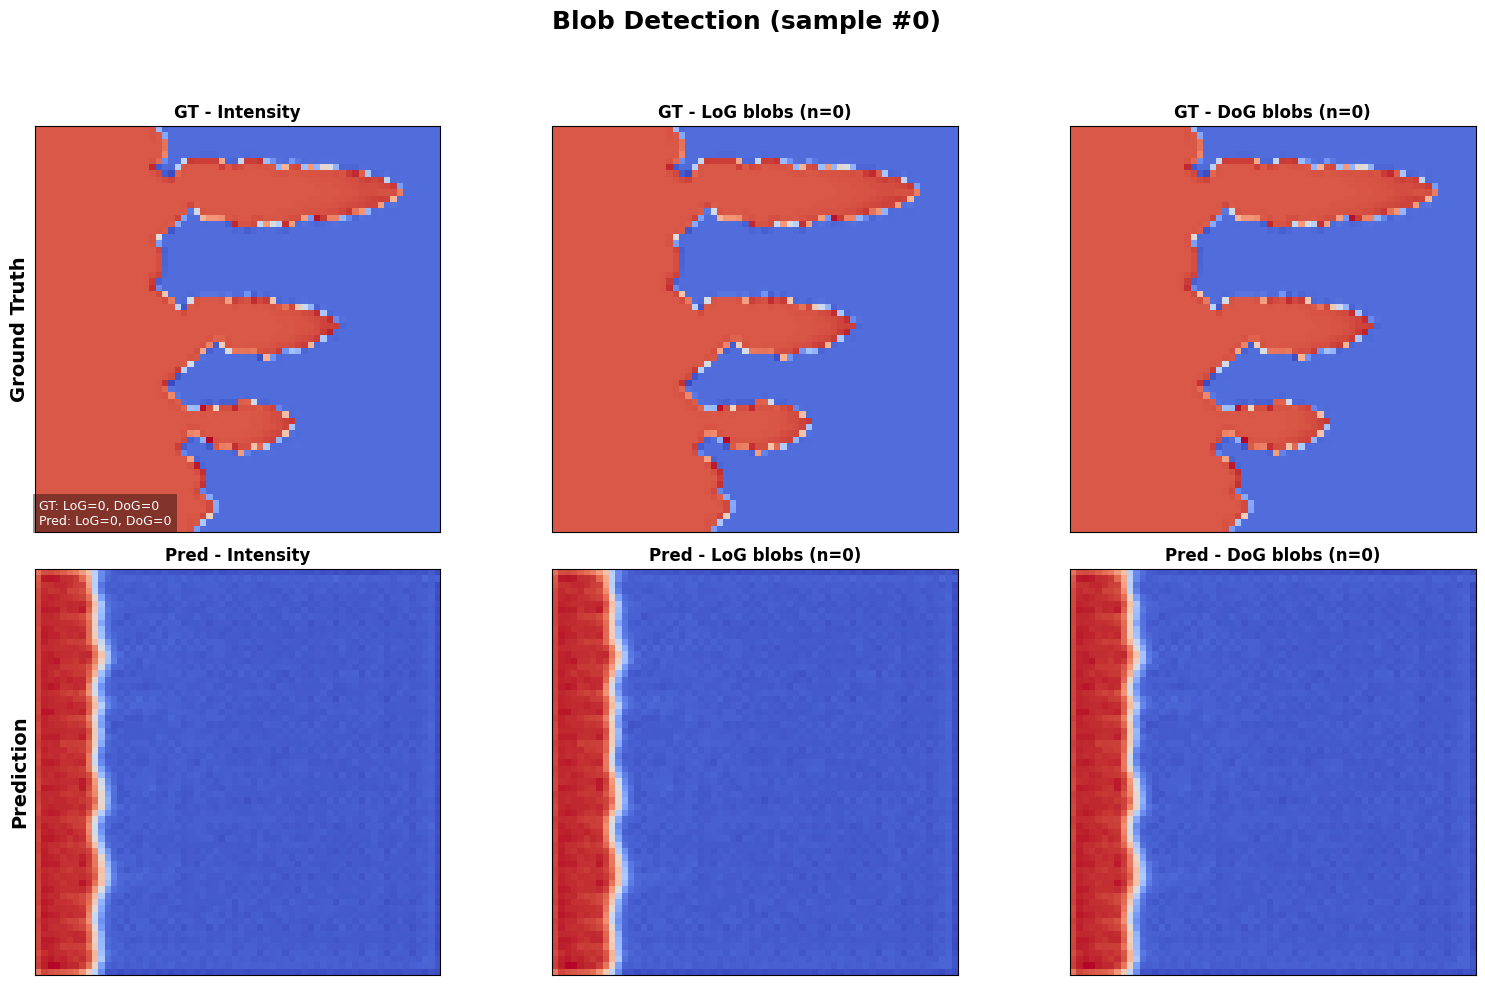

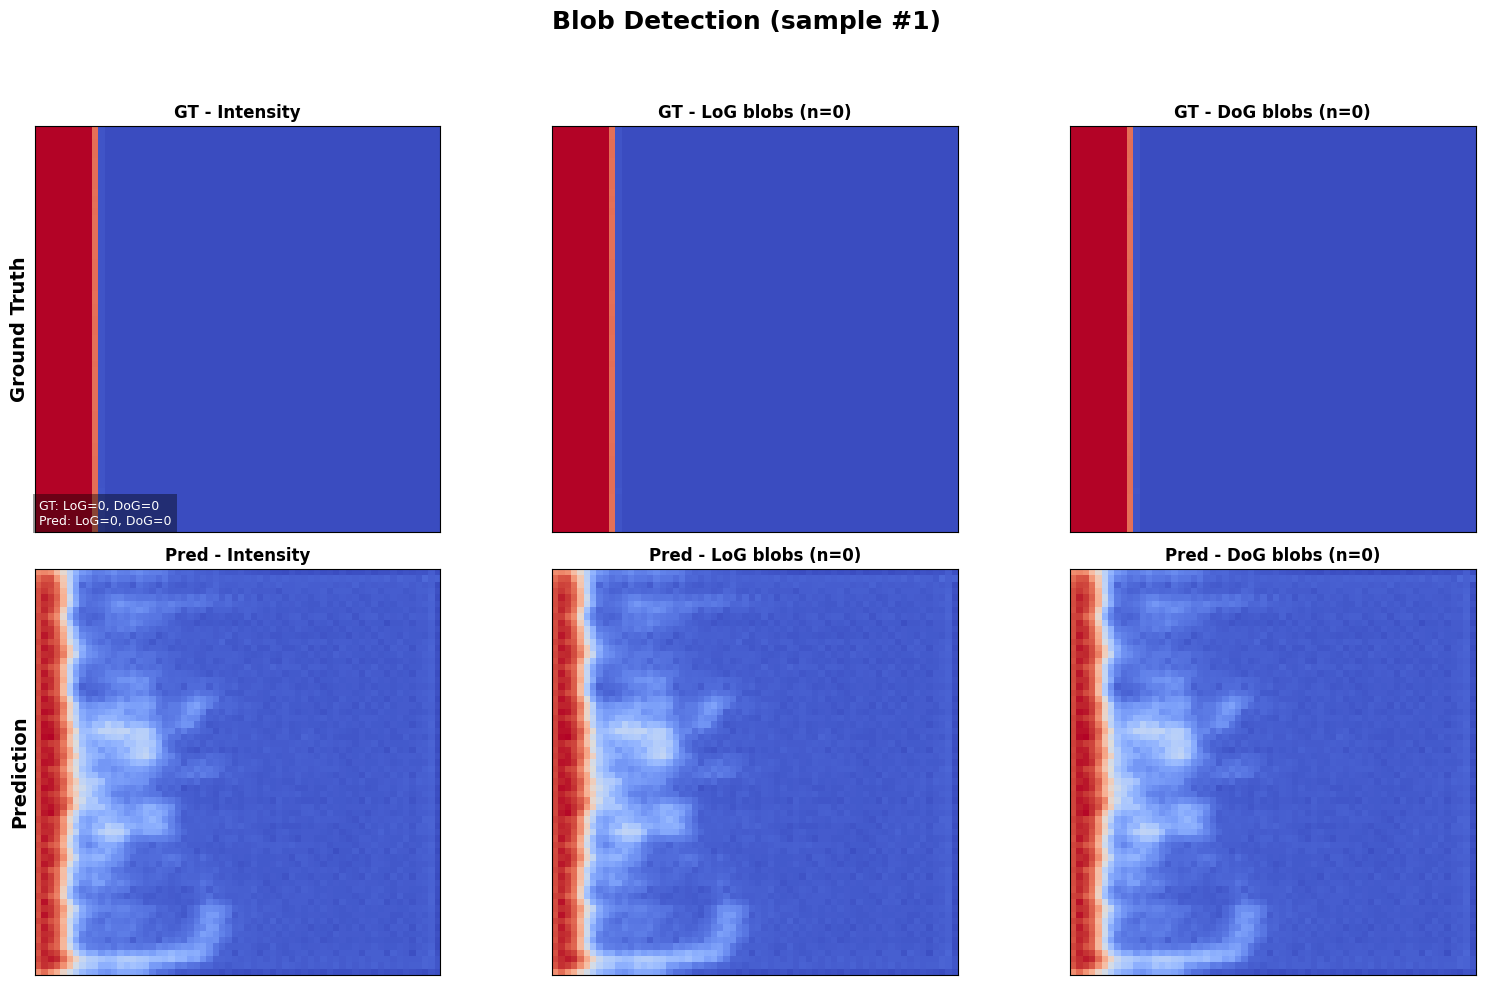

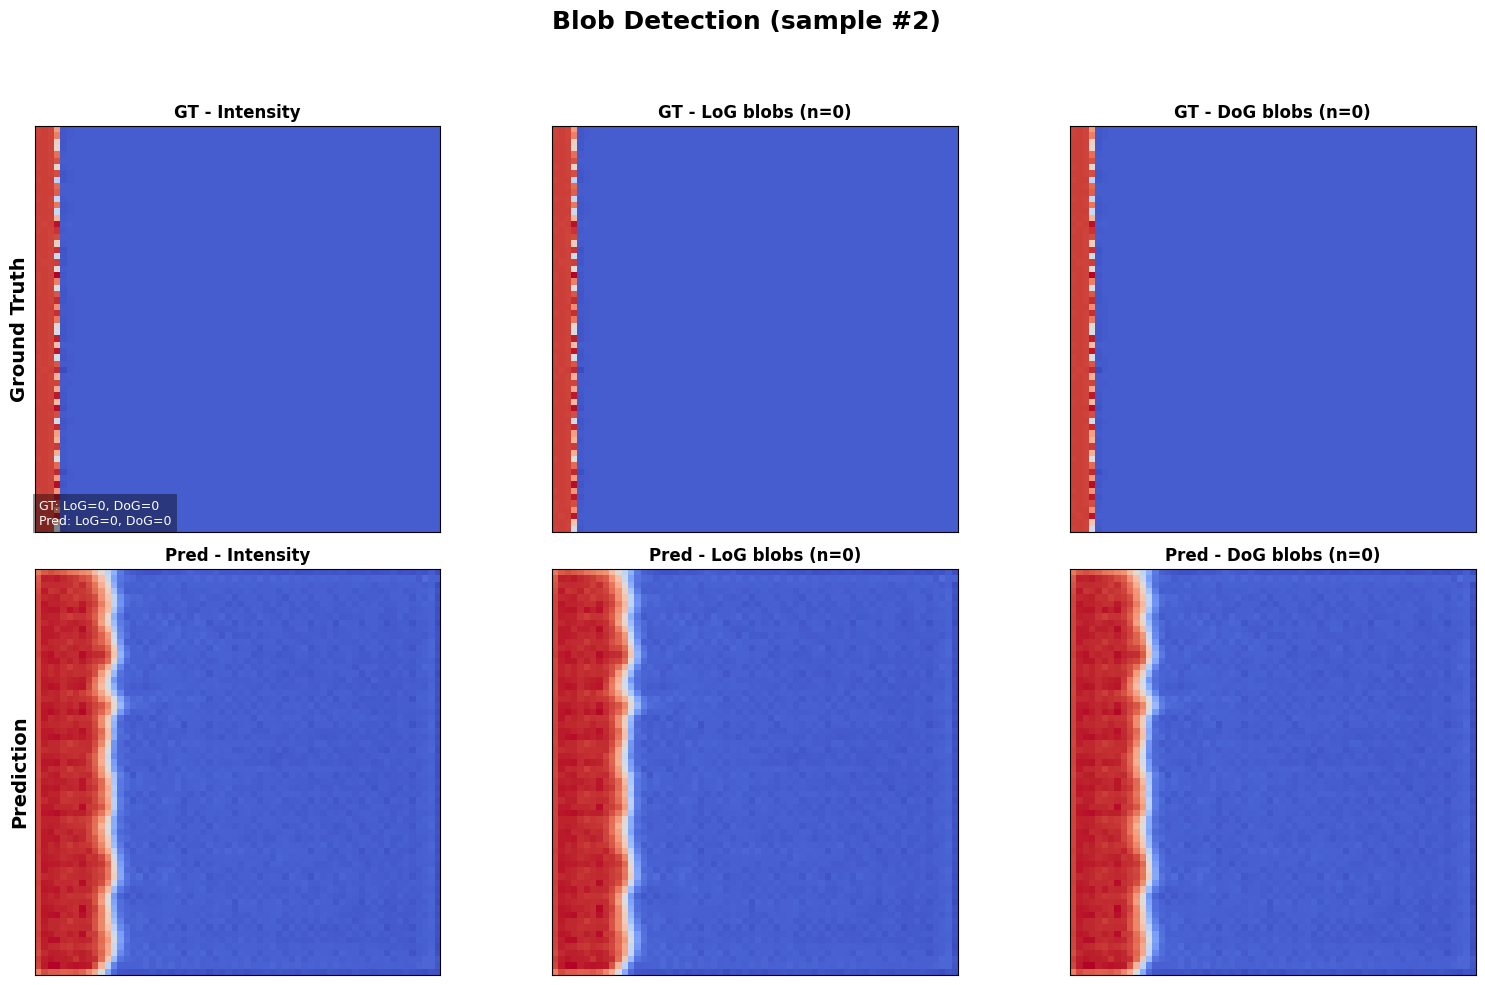

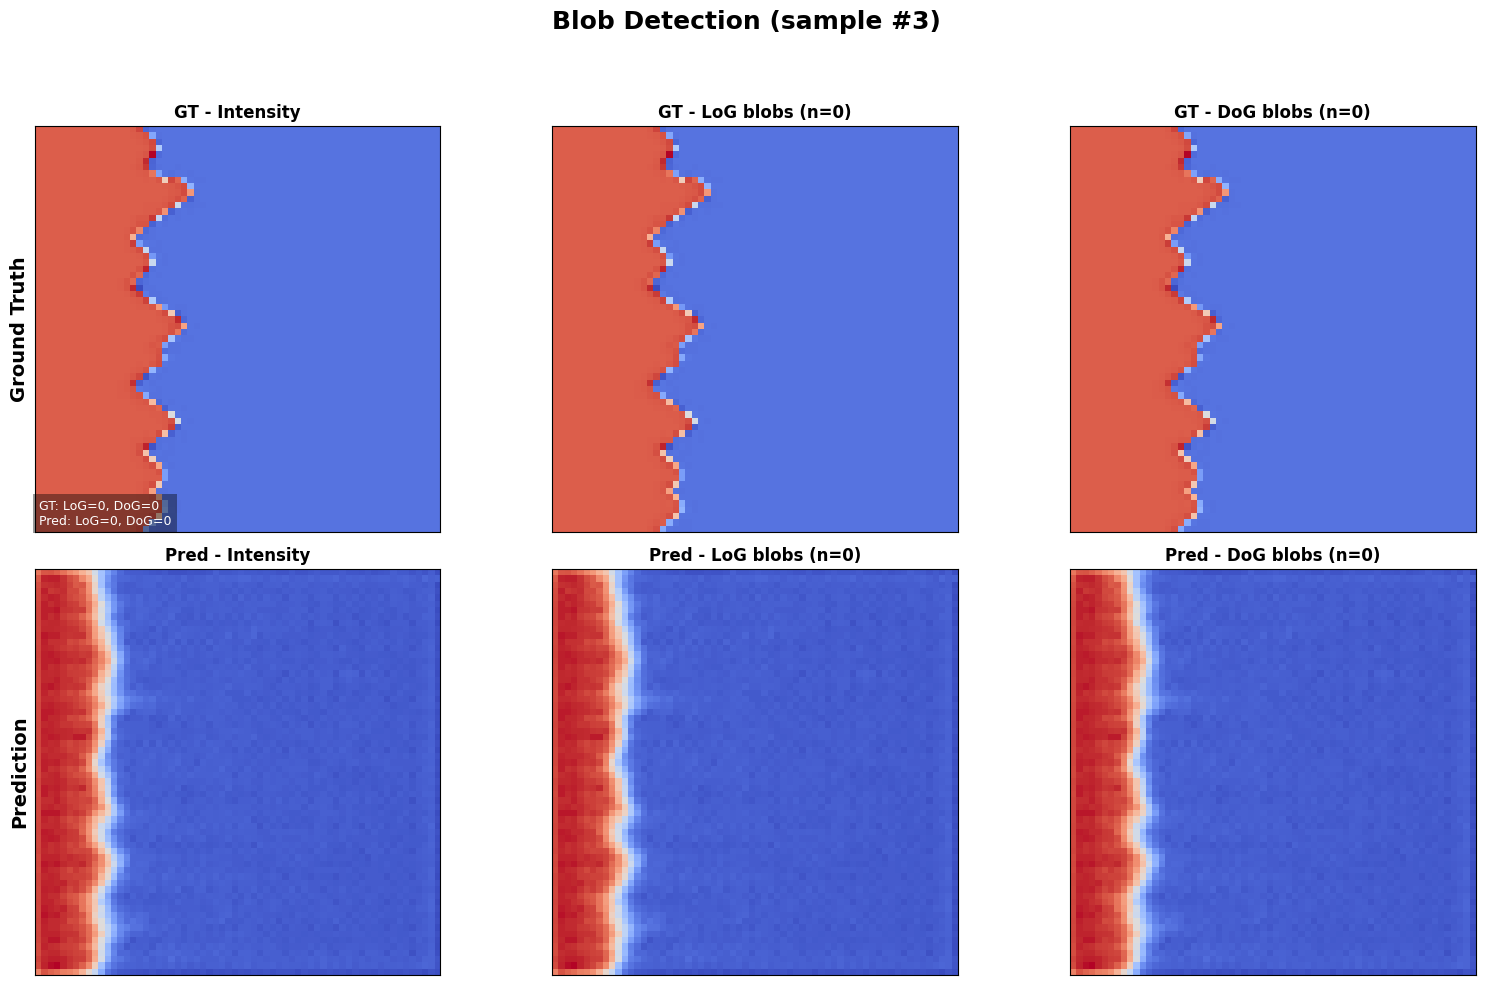

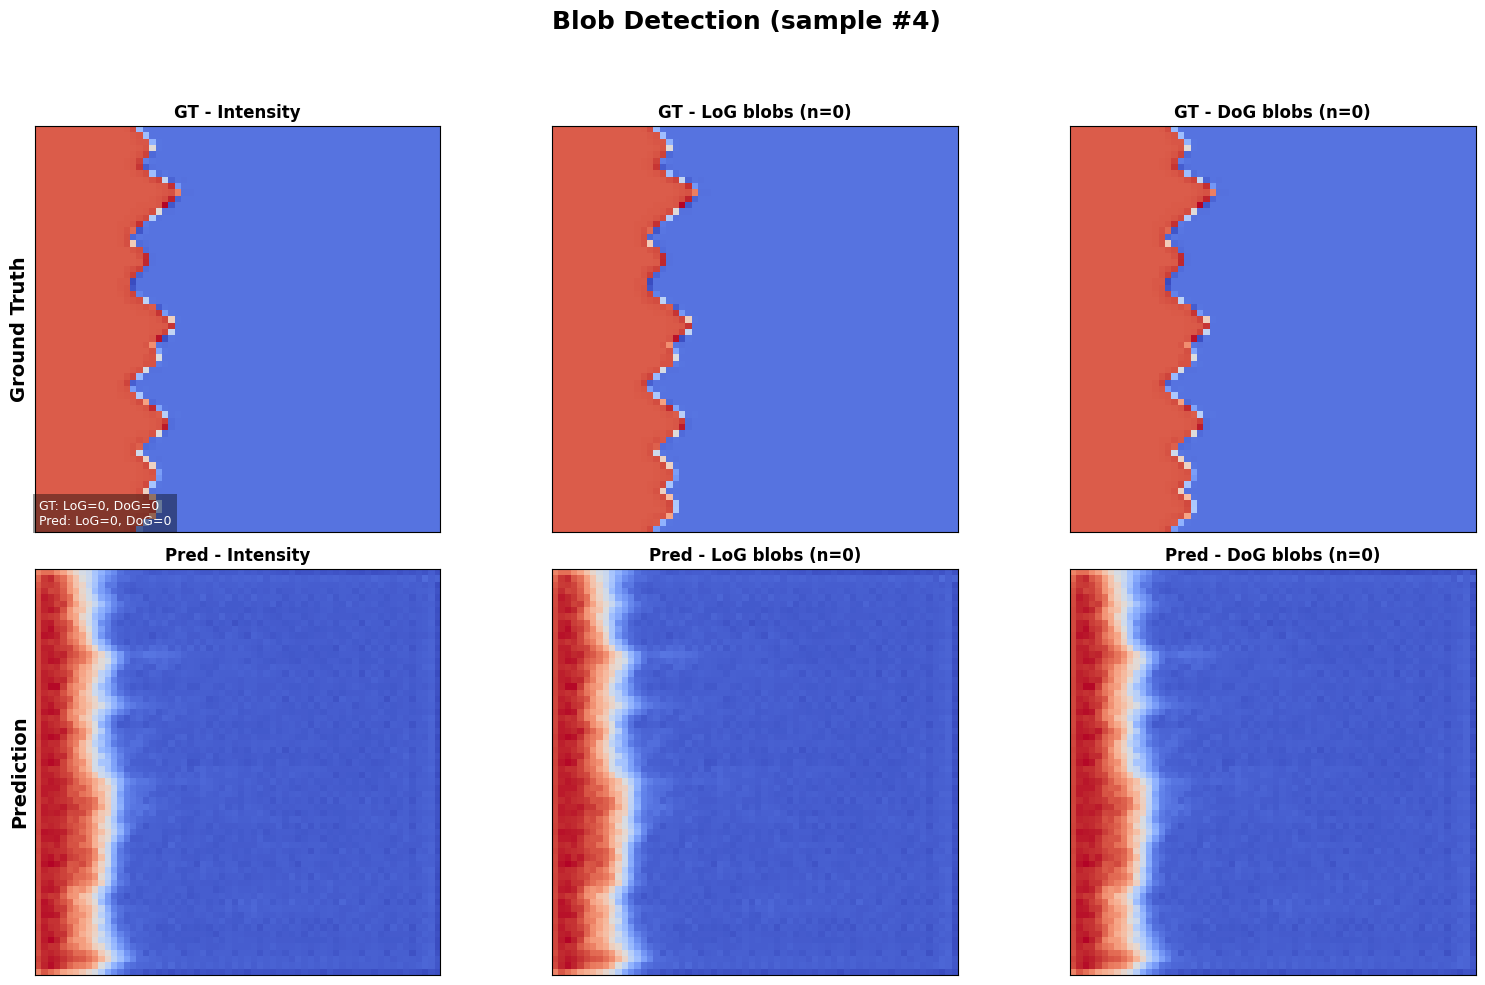

In [8]:
print(f"Blob detection visualization on {len(vis_samples)} random test samples (channel 0)")

for sample in vis_samples:
    idx = sample["idx"]
    x_s = sample["x"]
    recon_s = sample["recon_x"]

    img_gt = x_s.numpy()[0, 0, :, :]
    img_pd = recon_s.numpy()[0, 0, :, :]

    # LoG blobs
    log_gt = blob_log(img_gt, max_sigma=30, num_sigma=10, threshold=0.1)
    log_pd = blob_log(img_pd, max_sigma=30, num_sigma=10, threshold=0.1)
    log_gt[:, 2] *= sqrt(2)
    log_pd[:, 2] *= sqrt(2)

    # DoG blobs
    dog_gt = blob_dog(img_gt, max_sigma=30, threshold=0.1)
    dog_pd = blob_dog(img_pd, max_sigma=30, threshold=0.1)
    dog_gt[:, 2] *= sqrt(2)
    dog_pd[:, 2] *= sqrt(2)

    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    fig.suptitle(f"Blob Detection (sample #{idx})", fontsize=18, weight='bold')

    # Row 1: GT
    ax1, ax2, ax3 = axes[0]
    ax1.imshow(img_gt, cmap='coolwarm')
    ax1.set_title("GT - Intensity", fontsize=12, weight='bold')
    ax1.set_ylabel("Ground Truth", fontsize=14, weight='bold')

    ax2.imshow(img_gt, cmap='coolwarm')
    ax2.set_title(f"GT - LoG blobs (n={len(log_gt)})", fontsize=12, weight='bold')

    ax3.imshow(img_gt, cmap='coolwarm')
    ax3.set_title(f"GT - DoG blobs (n={len(dog_gt)})", fontsize=12, weight='bold')

    # draw GT blobs
    for y, x0, r in log_gt:
        ax2.add_patch(plt.Circle((x0, y), r, color='black', linewidth=2, fill=False))
    for y, x0, r in dog_gt:
        ax3.add_patch(plt.Circle((x0, y), r, color='black', linewidth=2, fill=False))

    # Row 2: Pred
    ax4, ax5, ax6 = axes[1]
    ax4.imshow(img_pd, cmap='coolwarm')
    ax4.set_title("Pred - Intensity", fontsize=12, weight='bold')
    ax4.set_ylabel("Prediction", fontsize=14, weight='bold')

    ax5.imshow(img_pd, cmap='coolwarm')
    ax5.set_title(f"Pred - LoG blobs (n={len(log_pd)})", fontsize=12, weight='bold')

    ax6.imshow(img_pd, cmap='coolwarm')
    ax6.set_title(f"Pred - DoG blobs (n={len(dog_pd)})", fontsize=12, weight='bold')

    for y, x0, r in log_pd:
        ax5.add_patch(plt.Circle((x0, y), r, color='black', linewidth=2, fill=False))
    for y, x0, r in dog_pd:
        ax6.add_patch(plt.Circle((x0, y), r, color='black', linewidth=2, fill=False))

    for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
        ax.tick_params(
            axis='both', labelsize=8,
            bottom=False, left=False,
            labelbottom=False, labelleft=False
        )

    # annotate summary in figure
    txt = (
        f"GT: LoG={len(log_gt)}, DoG={len(dog_gt)}\n"
        f"Pred: LoG={len(log_pd)}, DoG={len(dog_pd)}"
    )
    ax1.text(
        0.01, 0.01, txt,
        transform=ax1.transAxes,
        fontsize=9, color='white',
        verticalalignment='bottom',
        bbox=dict(facecolor='black', alpha=0.4, edgecolor='none')
    )

    plt.tight_layout(rect=[0, 0, 1, 0.94])
    plt.show()
